## **Setup and imports**


In [ ]:
# Install dependencies
!pip install torch torchvision numpy matplotlib

# Import necessary libraries
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import time

# Set random seed for reproducibility
seed = 999
random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 31.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

## **Mount Google Drive, set parameters**

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set data directory - adjust if your path is different
dataroot = "/content/drive/MyDrive/celeba/extracted"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images - All images will be resized to this
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode
ngpu = 1

# Directory for saving checkpoints
checkpoint_dir = "/content/drive/MyDrive/dcgan_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Starting epoch (useful for resuming training)
start_epoch = 0

Mounted at /content/drive


## **Load and prepare dataset**

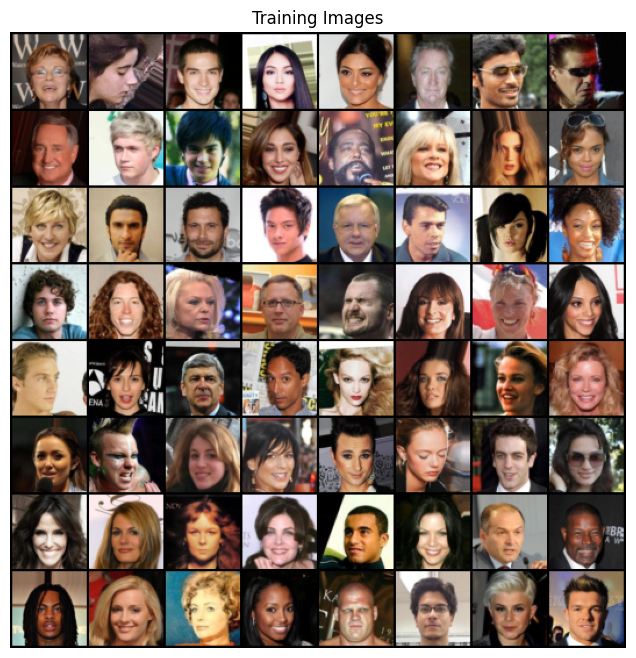

In [ ]:
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                          transform=transforms.Compose([
                              transforms.Resize(image_size),
                              transforms.CenterCrop(image_size),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                          ]))

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                        shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

## **Generator and Discriminator**

In [ ]:
# Custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
netG.apply(weights_init)

# Print the model
print(netG)

# Discriminator Code
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
netD.apply(weights_init)

# Print the model
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


## **Loss functions and optimizers**

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## **Checkpoint functions**

In [ ]:
# Function to clean up old checkpoints and keep only the last N
def cleanup_checkpoints(checkpoint_dir, keep_last_n=2, exclude_epochs=None):
    if exclude_epochs is None:
        exclude_epochs = []

    # Get all checkpoint files
    checkpoint_files = [f for f in os.listdir(checkpoint_dir)
                        if f.startswith('dcgan_checkpoint_epoch_') and f.endswith('.pt')]

    # Extract epoch numbers
    file_epochs = []
    for f in checkpoint_files:
        try:
            epoch = int(f.split('_')[-1].split('.')[0])
            file_epochs.append((epoch, f))
        except ValueError:
            continue

    # Sort by epoch number
    file_epochs.sort()

    # Keep only the last N checkpoints and any specifically excluded ones
    epochs_to_keep = set([ep for ep, _ in file_epochs[-keep_last_n:]] + exclude_epochs)

    # Delete the rest
    deleted_count = 0
    for epoch, filename in file_epochs:
        if epoch not in epochs_to_keep:
            os.remove(os.path.join(checkpoint_dir, filename))
            deleted_count += 1

    if deleted_count > 0:
        print(f"Deleted {deleted_count} old checkpoint files, keeping the last {keep_last_n} epochs")

# Function to save checkpoints
def save_checkpoint(epoch, netG, netD, optimizerG, optimizerD, G_losses, D_losses, img_list):
    checkpoint = {
        'epoch': epoch,
        'netG_state_dict': netG.state_dict(),
        'netD_state_dict': netD.state_dict(),
        'optimizerG_state_dict': optimizerG.state_dict(),
        'optimizerD_state_dict': optimizerD.state_dict(),
        'G_losses': G_losses,
        'D_losses': D_losses,
        'img_list': img_list
    }
    torch.save(checkpoint, f"{checkpoint_dir}/dcgan_checkpoint_epoch_{epoch}.pt")
    print(f"Checkpoint saved for epoch {epoch}")

    # Clean up old checkpoints, keeping only the last 2
    cleanup_checkpoints(checkpoint_dir, keep_last_n=2)

# Function to load checkpoints
def load_checkpoint(checkpoint_path, netG, netD, optimizerG, optimizerD):
    if os.path.isfile(checkpoint_path):
        print(f"Loading checkpoint from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path)
        start_epoch = checkpoint['epoch'] + 1
        netG.load_state_dict(checkpoint['netG_state_dict'])
        netD.load_state_dict(checkpoint['netD_state_dict'])
        optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])
        optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])
        G_losses = checkpoint['G_losses']
        D_losses = checkpoint['D_losses']
        img_list = checkpoint.get('img_list', [])  # Handle older checkpoints without img_list
        print(f"Checkpoint loaded. Resuming from epoch {start_epoch}")
        return start_epoch, G_losses, D_losses, img_list
    else:
        print("No checkpoint found. Starting from scratch.")
        return 0, [], [], []

## **Training loop**

In [ ]:

# Create directory for progress images
progress_img_dir = "/content/drive/MyDrive/dcgan_progress_images"
os.makedirs(progress_img_dir, exist_ok=True)

# Initialize training variables
G_losses = []
D_losses = []
img_list = []

# Check if we're resuming training
resume_training = True  # Set this to True if you want to resume
checkpoint_epoch = 30  # Set to the epoch number you want to resume from, or None for latest

# Find the latest checkpoint if no specific checkpoint is specified
if resume_training:
    if checkpoint_epoch is None:
        # Find the latest checkpoint
        checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.startswith('dcgan_checkpoint_epoch_')]
        if checkpoint_files:
            checkpoint_epochs = [int(f.split('_')[-1].split('.')[0]) for f in checkpoint_files]
            checkpoint_epoch = max(checkpoint_epochs)
            print(f"Found latest checkpoint at epoch {checkpoint_epoch}")

    if checkpoint_epoch is not None:
        checkpoint_path = f"{checkpoint_dir}/dcgan_checkpoint_epoch_{checkpoint_epoch}.pt"
        start_epoch, G_losses, D_losses, img_list = load_checkpoint(checkpoint_path, netG, netD, optimizerG, optimizerD)
    else:
        print("No checkpoints found. Starting from scratch.")
        start_epoch = 0
else:
    start_epoch = 0
    print("Starting new training run")

print(f"Starting training from epoch {start_epoch}")

# Create fixed noise for visualizing progress
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Training Loop
for epoch in range(start_epoch, num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (i % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_grid = vutils.make_grid(fake, padding=2, normalize=True)
            img_list.append(img_grid)

    # End of epoch processing

    # Generate and save progress images after each epoch
    with torch.no_grad():
        # Generate images with fixed noise vector
        fake = netG(fixed_noise).detach().cpu()
        img_grid = vutils.make_grid(fake, padding=2, normalize=True)

        # Convert to numpy and transpose for plotting
        img_np = np.transpose(img_grid, (1, 2, 0))

        # Plot and save the image grid
        plt.figure(figsize=(12, 8))
        plt.axis("off")
        plt.title(f"Generator Output - Epoch {epoch}")
        plt.imshow(img_np)

        # Save figure to Google Drive
        plt.savefig(f"{progress_img_dir}/epoch_{epoch:03d}.png",
                   bbox_inches='tight', pad_inches=0.1)

        # Show the image (will display in notebook)
        plt.show()

        # Also save as tensor grid (optional)
        vutils.save_image(fake, f"{progress_img_dir}/tensor_epoch_{epoch:03d}.png",
                         normalize=True)

    # Plot current training losses
    plt.figure(figsize=(10, 5))
    plt.title(f"Generator and Discriminator Loss - Up to Epoch {epoch}")
    plt.plot(G_losses, label="G")
    plt.plot(D_losses, label="D")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f"{progress_img_dir}/losses_epoch_{epoch:03d}.png")
    plt.show()

    # Save checkpoint for current epoch - system will automatically delete old ones
    save_checkpoint(epoch, netG, netD, optimizerG, optimizerD, G_losses, D_losses, img_list)

    # Always keep the latest checkpoint for quick resuming
    torch.save({
        'epoch': epoch,
        'netG_state_dict': netG.state_dict(),
        'netD_state_dict': netD.state_dict(),
        'optimizerG_state_dict': optimizerG.state_dict(),
        'optimizerD_state_dict': optimizerD.state_dict(),
        'G_losses': G_losses,
        'D_losses': D_losses,
        'img_list': img_list
    }, f"{checkpoint_dir}/dcgan_latest.pt")

    # Print progress
    print(f"Epoch {epoch}/{num_epochs} complete")
    print(f"Progress: {(epoch+1)/num_epochs*100:.1f}% done")

    # Estimate time remaining (after first epoch)
    if epoch > start_epoch:
        import time
        time_elapsed = time.time() - epoch_start_time
        time_per_epoch = time_elapsed / (epoch - start_epoch + 1)
        remaining_epochs = num_epochs - epoch - 1
        estimated_time = time_per_epoch * remaining_epochs

        # Convert to hours, minutes, seconds
        hours = int(estimated_time // 3600)
        minutes = int((estimated_time % 3600) // 60)
        seconds = int(estimated_time % 60)

        print(f"Estimated time remaining: {hours}h {minutes}m {seconds}s")

    # Record the start time for the next epoch
    epoch_start_time = time.time()

print("Training complete!")

## **Generate fake images and visualize**

Generating a 8x8 grid of random faces...


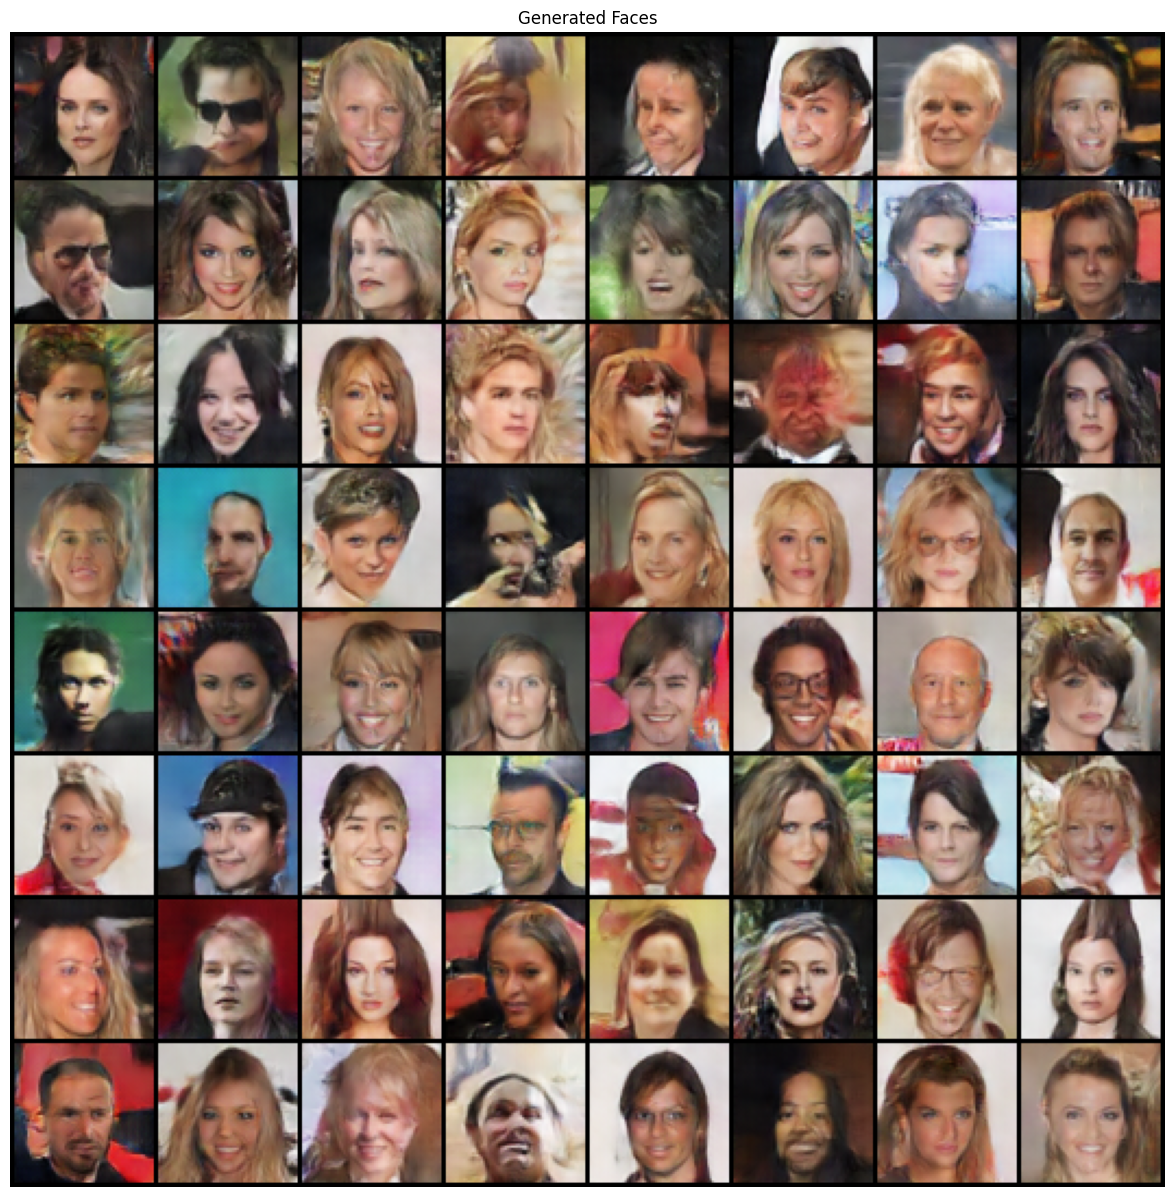

Saved individual images to /content/drive/MyDrive/dcgan_generated_images
Generating latent space interpolation visualization...


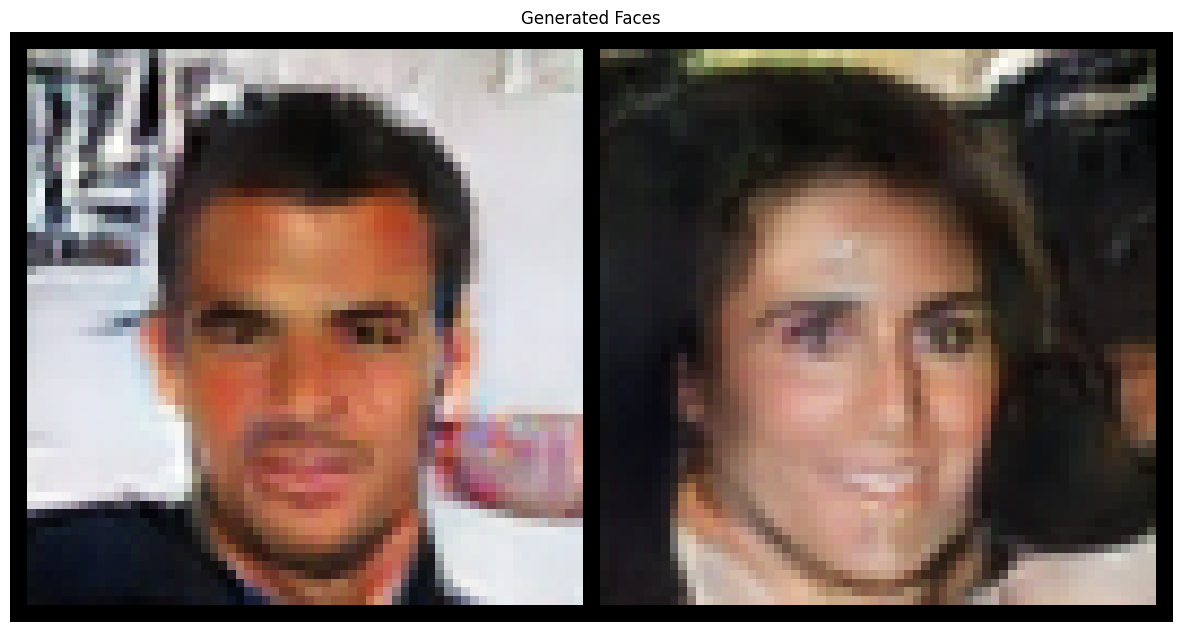

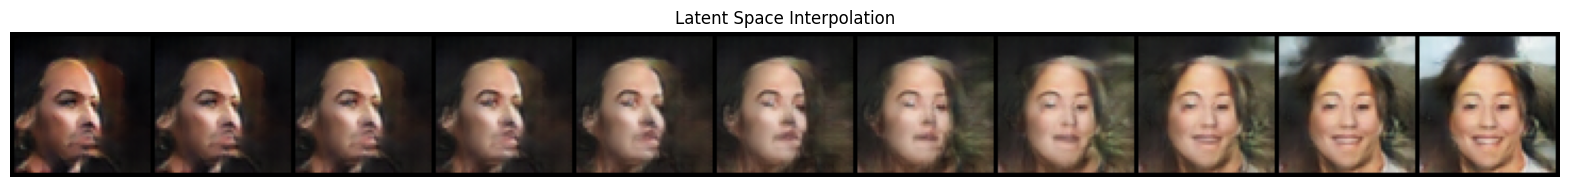

Generating style mixing visualization...


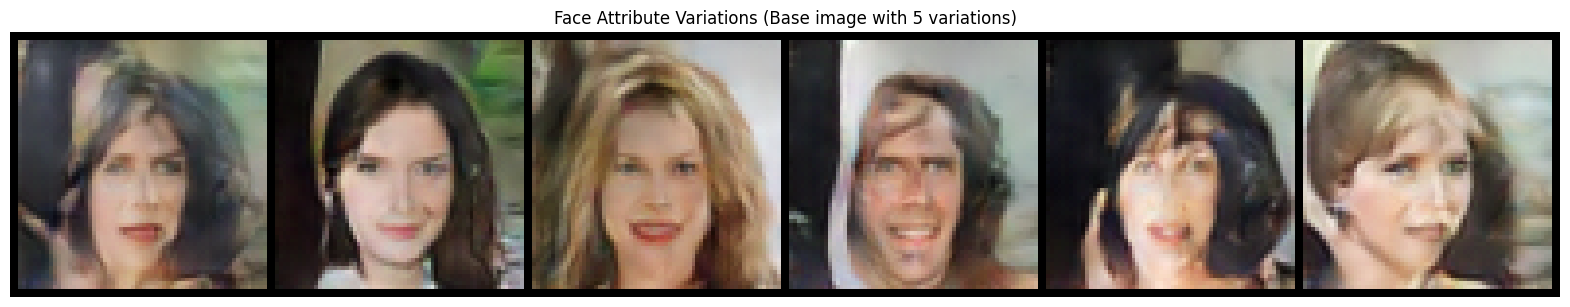

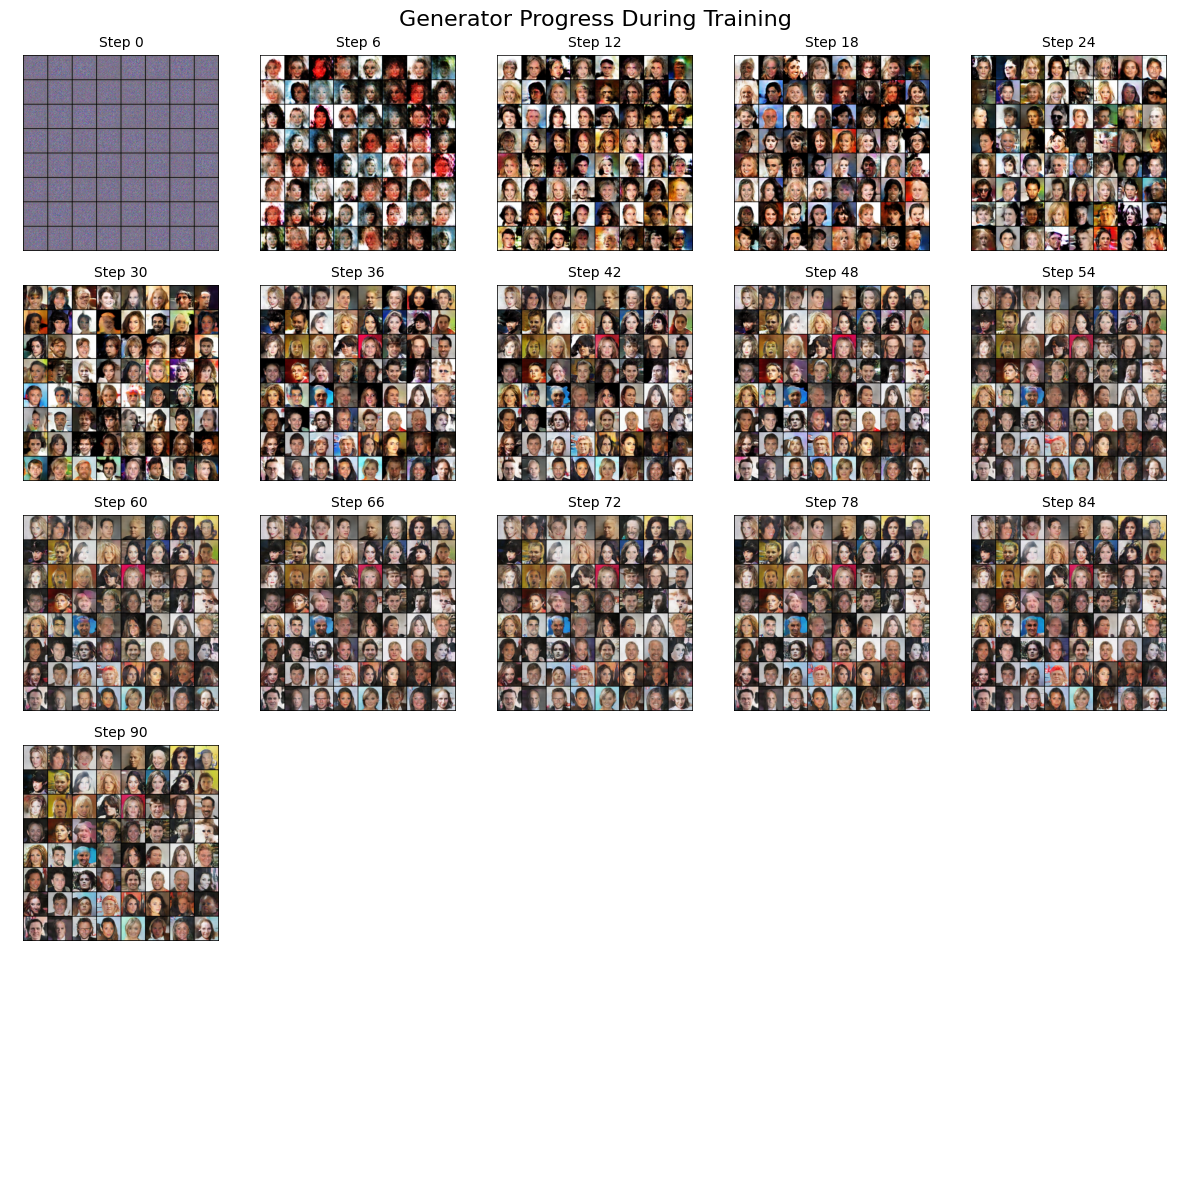

In [ ]:
# Function to generate multiple fake images with enhanced visualization
def generate_fake_images(netG, num_images=16, nz=100, device='cpu', grid_size=None,
                         save_dir=None, show_interpolation=False):
    # Set evaluation mode
    netG.eval()

    # Default grid size as square
    if grid_size is None:
        grid_size = (int(num_images**0.5), int(num_images**0.5))
        if grid_size[0] * grid_size[1] < num_images:
            grid_size = (grid_size[0], grid_size[1] + 1)

    # Generate random noise
    with torch.no_grad():
        noise = torch.randn(num_images, nz, 1, 1, device=device)
        fake_images = netG(noise).detach().cpu()

    # Create a grid of images
    grid = vutils.make_grid(fake_images, padding=2, normalize=True, nrow=grid_size[1])

    # Convert to numpy for display
    grid_np = np.transpose(grid, (1, 2, 0))

    # Plot and display
    plt.figure(figsize=(15, 15))
    plt.axis("off")
    plt.title("Generated Faces")
    plt.imshow(grid_np)
    plt.show()

    # Save individual images if requested
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        for i in range(min(16, num_images)):  # Save up to 16 images
            img = fake_images[i]
            # Unnormalize the image
            img = (img + 1) / 2.0
            # Convert to PIL image
            img_pil = transforms.ToPILImage()(img)
            # Save the image
            img_pil.save(f"{save_dir}/generated_face_{i}.png")
        print(f"Saved individual images to {save_dir}")

    # Generate and visualize interpolation in latent space
    if show_interpolation:
        # Generate two random points in latent space
        z1 = torch.randn(1, nz, 1, 1, device=device)
        z2 = torch.randn(1, nz, 1, 1, device=device)

        # Generate images at intermediate points
        num_steps = 10
        interpolated_images = []

        for step in range(num_steps + 1):
            # Linear interpolation between z1 and z2
            alpha = step / num_steps
            z_interp = z1 * (1 - alpha) + z2 * alpha

            # Generate image
            with torch.no_grad():
                img = netG(z_interp).detach().cpu()
                interpolated_images.append(img[0])

        # Create a grid of interpolated images
        interp_grid = vutils.make_grid(interpolated_images, padding=2, normalize=True, nrow=num_steps+1)
        interp_grid_np = np.transpose(interp_grid, (1, 2, 0))

        # Plot interpolation
        plt.figure(figsize=(20, 4))
        plt.axis("off")
        plt.title("Latent Space Interpolation")
        plt.imshow(interp_grid_np)
        plt.show()

    return fake_images

# Enhanced visualization: Generate a larger grid of faces
print("Generating a 8x8 grid of random faces...")
fake_images = generate_fake_images(netG, num_images=64, nz=nz, device=device, grid_size=(8, 8),
                                   save_dir="/content/drive/MyDrive/dcgan_generated_images")

# Show latent space interpolation
print("Generating latent space interpolation visualization...")
_ = generate_fake_images(netG, num_images=2, nz=nz, device=device, show_interpolation=True)

# Generate and visualize face attributes variation
print("Generating style mixing visualization...")
def visualize_style_mixing(netG, nz=100, device='cpu'):
    # Set to eval mode
    netG.eval()

    # Generate base vector
    base_vector = torch.randn(1, nz, 1, 1, device=device)

    # Create variations by modifying different dimensions
    num_variations = 5
    variation_vectors = []
    variation_images = []

    # Generate base image
    with torch.no_grad():
        base_image = netG(base_vector).detach().cpu()
        variation_images.append(base_image[0])

    # Generate variations
    for i in range(num_variations):
        # Copy base vector and modify a random subset of dimensions
        var_vector = base_vector.clone()
        # Randomly select 10% of dimensions to modify
        num_dims = int(0.1 * nz)
        dims_to_modify = np.random.choice(nz, num_dims, replace=False)

        # Modify the selected dimensions
        for dim in dims_to_modify:
            var_vector[0, dim, 0, 0] = torch.randn(1).item() * 2  # Stronger variation

        # Generate image from modified vector
        with torch.no_grad():
            var_image = netG(var_vector).detach().cpu()
            variation_images.append(var_image[0])

    # Create a grid of images
    var_grid = vutils.make_grid(variation_images, padding=2, normalize=True, nrow=len(variation_images))
    var_grid_np = np.transpose(var_grid, (1, 2, 0))

    # Plot variations
    plt.figure(figsize=(20, 4))
    plt.axis("off")
    plt.title("Face Attribute Variations (Base image with 5 variations)")
    plt.imshow(var_grid_np)
    plt.show()

# Visualize style mixing
visualize_style_mixing(netG, nz=nz, device=device)

# Create a montage of progressively improving generator outputs during training
if len(img_list) > 0:
    # Plot the progression of generator outputs during training
    fig = plt.figure(figsize=(12, 12))
    plt.axis("off")

    # Select images evenly spaced through training
    max_images = min(16, len(img_list))
    step_size = max(1, len(img_list) // max_images)
    selected_images = [img_list[i] for i in range(0, len(img_list), step_size)][:max_images]

    # Plot images in a grid
    for i, img in enumerate(selected_images):
        plt.subplot(int(np.sqrt(max_images)) + 1, int(np.sqrt(max_images)) + 1, i+1)
        plt.axis("off")
        plt.title(f"Step {i*step_size}", fontsize=10)
        plt.imshow(np.transpose(img, (1, 2, 0)))

    plt.suptitle("Generator Progress During Training", fontsize=16)
    plt.tight_layout()
    plt.show()

## **Save final states**

In [ ]:
# Cell to save final model states to Google Drive

def save_final_models(netG, netD, optimizerG, optimizerD, G_losses, D_losses, save_dir=None):
    """
    Save final trained models and training history to Google Drive.

    Args:
        netG: The generator model
        netD: The discriminator model
        optimizerG: Generator optimizer
        optimizerD: Discriminator optimizer
        G_losses: List of generator losses
        D_losses: List of discriminator losses
        save_dir: Directory to save models (default: /content/drive/MyDrive/dcgan_models)
    """
    # Set default save directory if not provided
    if save_dir is None:
        save_dir = "/content/drive/MyDrive/dcgan_models"

    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    # Save timestamp for unique naming
    import datetime
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

    # Save Generator model
    torch.save({
        'model_state_dict': netG.state_dict(),
        'optimizer_state_dict': optimizerG.state_dict(),
        'losses': G_losses,
        'hyperparameters': {
            'nz': nz,
            'ngf': ngf,
            'nc': nc
        }
    }, f"{save_dir}/generator_final_{timestamp}.pth")

    # Save Discriminator model
    torch.save({
        'model_state_dict': netD.state_dict(),
        'optimizer_state_dict': optimizerD.state_dict(),
        'losses': D_losses,
        'hyperparameters': {
            'ndf': ndf,
            'nc': nc
        }
    }, f"{save_dir}/discriminator_final_{timestamp}.pth")

    # Save full training state (more comprehensive)
    torch.save({
        'generator_state_dict': netG.state_dict(),
        'discriminator_state_dict': netD.state_dict(),
        'generator_optimizer_state_dict': optimizerG.state_dict(),
        'discriminator_optimizer_state_dict': optimizerD.state_dict(),
        'G_losses': G_losses,
        'D_losses': D_losses,
        'hyperparameters': {
            'nz': nz,
            'ngf': ngf,
            'ndf': ndf,
            'nc': nc,
            'lr': lr,
            'beta1': beta1,
            'image_size': image_size
        }
    }, f"{save_dir}/dcgan_full_model_{timestamp}.pth")

    # Save losses separately for easy plotting later
    import json
    with open(f"{save_dir}/training_losses_{timestamp}.json", 'w') as f:
        json.dump({
            'G_losses': [float(loss) for loss in G_losses],
            'D_losses': [float(loss) for loss in D_losses]
        }, f)

    print(f"Models saved successfully to {save_dir}:")
    print(f"- Generator: generator_final_{timestamp}.pth")
    print(f"- Discriminator: discriminator_final_{timestamp}.pth")
    print(f"- Full model state: dcgan_full_model_{timestamp}.pth")
    print(f"- Training losses: training_losses_{timestamp}.json")

    return f"{save_dir}/dcgan_full_model_{timestamp}.pth"

# Save the final models
final_model_path = save_final_models(netG, netD, optimizerG, optimizerD, G_losses, D_losses)

# Additional cell for loading these saved models later
def load_saved_model(model_path):
    """
    Load a saved model for inference.

    Args:
        model_path: Path to the saved model file

    Returns:
        netG: Loaded generator model
        netD: Loaded discriminator model
    """
    # Load the saved model
    checkpoint = torch.load(model_path)

    # Recreate the models
    if 'hyperparameters' in checkpoint:
        # Use saved hyperparameters
        params = checkpoint['hyperparameters']
        local_nz = params.get('nz', 100)
        local_ngf = params.get('ngf', 64)
        local_ndf = params.get('ndf', 64)
        local_nc = params.get('nc', 3)
    else:
        # Use default hyperparameters
        local_nz, local_ngf, local_ndf, local_nc = 100, 64, 64, 3

    # Create models
    netG = Generator(ngpu).to(device)
    netD = Discriminator(ngpu).to(device)

    # Load state dictionaries
    if 'generator_state_dict' in checkpoint:
        netG.load_state_dict(checkpoint['generator_state_dict'])
        netD.load_state_dict(checkpoint['discriminator_state_dict'])
    elif 'model_state_dict' in checkpoint and model_path.find('generator') >= 0:
        netG.load_state_dict(checkpoint['model_state_dict'])
        print("Loaded generator only")

    print(f"Model loaded successfully from {model_path}")
    return netG, netD

# Example usage (uncomment to load models)
# model_path = "/content/drive/MyDrive/dcgan_models/dcgan_full_model_YYYYMMDD_HHMMSS.pth"  # Replace with your saved model path
# loaded_netG, loaded_netD = load_saved_model(model_path)

Models saved successfully to /content/drive/MyDrive/dcgan_models:
- Generator: generator_final_20250426_141133.pth
- Discriminator: discriminator_final_20250426_141133.pth
- Full model state: dcgan_full_model_20250426_141133.pth
- Training losses: training_losses_20250426_141133.json
